In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
from lib import get_stop_words, get_text, get_lem_words
from multiprocessing import Pool
from itertools import repeat, chain
import pickle

In [3]:
NUM_PROCESSES = 20

In [106]:
# project gutenberg text has a lot of extra stuff at the beginning and end
def get_text_no_gutenberg(raw_text):
    return re.split('^\*\*\*(.*)\*\*\*$', raw_text, flags=re.MULTILINE)[2]
    
def remove_single_letter(text):
    text = re.sub(r'\b\w\b', ' ', text)
    return text

# split the raw text into chapters
def split_chapters(text, roman_numeral=True):
    if roman_numeral:
        return re.split(r'(^\s?CHAPTER [IVXLCDM]+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)
    else:
        return re.split(r'(^\s?CHAPTER \d+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)

# sometimes the contents lists chapters that are in table of contents. here we just remove chapters that are too short.
# here we also delete the first chapter, which is just the table of contents and preface
def chapter_longer_than(raw_chapters, n=150):
    return list(filter(lambda c: len(c) > n, raw_chapters))

# split remove stopwords
def remove_stopwords(text, stopwords):
    return re.sub(r'\b(' + '|'.join(stopwords) + r')\b', '', text)

def expand_contractions(text):
    flags = re.MULTILINE | re.IGNORECASE | re.ASCII
    text = re.sub(r'’', "'", text, flags=flags)
    text = re.sub(r"won\'t", r"will not", text, flags=flags)
    text = re.sub(r"can\'t", r"cannot", text, flags=flags)
    text = re.sub(r"i\'m", r"i am", text, flags=flags)
    text = re.sub(r"ain\'t", r"is not", text, flags=flags)
    text = re.sub(r"(\w+)'ll", r"\g<1> will", text, flags=flags)
    text = re.sub(r"(\w+)n't", '\g<1> not', text, flags=flags)
    text = re.sub(r"(\w+)\'ve", r"\g<1> have", text, flags=flags)
    text = re.sub(r"(\w+)\'s", r"\g<1> is", text, flags=flags)
    text = re.sub(r"(\w+)\'re", r"\g<1> are", text, flags=flags)
    text = re.sub(r"(\w+)\'d", r"\g<1> would", text, flags=flags)
    return text

# theres a ton of whitespace that we dont want
def remove_extra_spaces(text):
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def replace_common_dots(text):
    text =  re.sub(r'dr\.', 'dr ', text)
    text =  re.sub(r'mr\. ', 'mr ', text)
    return text

def compress_abbr(text):
    pattern = r'\b(?:[a-zA-Z]\.){2,}\b.*?'
    matches = re.finditer(pattern, text, re.MULTILINE | re.IGNORECASE)
    abbr = set(map(lambda m: m.group(), matches))
    for a in abbr:
        text = text.replace(a, a.replace('.', ''))
    return text

def get_lem(fn):
    lem = {}
    lem_regex = []
    with open(fn, 'r', encoding='utf-8-sig') as f:
        for i in f:
            text = [j for j in i.lower().split()]
            if text[0] not in lem:
                lem[text[0]] = [text[1]]
            else:
                lem[text[0]].append(text[1])
    for word, lemmas in lem.items():
        lem_regex.append([word, fr'\b({"|".join(lemmas)})\b'])
    return lem_regex
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', lambda m: "." if m.group(0) == "." else " ", text)
    return text

def split_sentences(text):
    return re.split(r"[.]", text)

def lemmatization(text, lem):
    for lemma, lem_regex in lem:
        text = re.sub(lem_regex, lemma, text)
    return text

def trim(text):
    for i in range(len(text)):
        text[i] = text[i].strip()
    return text

In [107]:
books = [
    {
        'fn': 'a-study-in-scarlet.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-valley-of-fear.txt',
        'roman_numeral': False,
        'remove_first_chapter': True
    },
    {
        'fn': 'the-hound-of-the-baskervilles.txt',
        'roman_numeral': False,
        'remove_first_chapter': True,
    },
    {
        'fn':  'the-mystery-of-cloomber.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-sign-of-four.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
]

In [124]:
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')
book_i = 2
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']


def clean_by_chapter(raw_chapter, stop_words, lem):
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = expand_contractions(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = replace_common_dots(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = compress_abbr(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = remove_punctuation(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = remove_stopwords(raw_chapter, stop_words)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = lemmatization(raw_chapter, lem)
    raw_chapter = remove_extra_spaces(raw_chapter)
    return raw_chapter


def clean_all_text(book_fn, base_dir, stop_words, lem, book_rom_num, remove_first_chapter):

    # get the raw text and make it all lower case
    raw_text = get_text(book_fn, base_dir)
    raw_text = raw_text.lower()
    raw_text = get_text_no_gutenberg(raw_text)

    # split into chapters so we can parallelize all of the text operations
    raw_chapters = split_chapters(raw_text, book_rom_num)

    # keep only the chapter's texts and none of the preface and content info
    longer_than_n = list(map(lambda c: len(c) > 100, raw_chapters))
    longer_than_n[0] = longer_than_n[0] if not remove_first_chapter else False
    chapt_start = next(i for i,v in enumerate(longer_than_n) if v)
    raw_chapters = raw_chapters[chapt_start::2]

    # map the cleaning operations onto each chapter
    with Pool(NUM_PROCESSES) as pool:
        raw_chapters = pool.starmap(clean_by_chapter, zip(raw_chapters, repeat(stop_words), repeat(lem)))

    # split each chapter into sentences
    def sentence_helper(text):
        s = split_sentences(text)
        s = trim(s)
        s = list(filter(lambda x: x != '', s))
        return s
    raw_chapter_sentences = list(map(sentence_helper, raw_chapters))

    # rejoin the sentences from the cleaned chapter sentences so we can remove empty sentences
    raw_chapters = list(map(lambda x: '. '.join(x), raw_chapter_sentences))
    raw_chapters = list(map(remove_extra_spaces, raw_chapters))

    # rejoin the clean text by joining all of the chapters sentences
    raw_text = '. '.join(chain(*raw_chapter_sentences))
    raw_text = remove_extra_spaces(raw_text)

    # here we are seperating each sentence by new line and appending the chapter and sentence number to the beginning of each sentence
    marked_text = ''
    for i in range(len(raw_chapter_sentences)):
        for j in range(len(raw_chapter_sentences[i])):
            marked_text += f'((({i};;;{j}))) {raw_chapter_sentences[i][j]}\n'
    return raw_text, raw_chapters, raw_chapter_sentences, marked_text



In [125]:
book_i = 0
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num, remove_first_chapter)


In [126]:
# save the cleaned text
def save_cleaned_text(book_fn, base_dir, raw_text, raw_chapters, raw_chapter_sentences, marked_text):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'w', encoding='utf-8') as f:
        f.write(raw_text)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'wb') as f:
        pickle.dump(raw_chapters, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'wb') as f:
        pickle.dump(raw_chapter_sentences, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'w', encoding='utf-8') as f:
        f.write(marked_text)

# read in the cleaned text
def read_cleaned_text(book_fn, base_dir):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'r', encoding='utf-8') as f:
        raw_text = f.read()
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'rb') as f:
        raw_chapters = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'rb') as f:
        raw_chapter_sentences = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'r', encoding='utf-8') as f:
        marked_text = f.read()

    return raw_text, raw_chapters, raw_chapter_sentences, marked_text

In [127]:
# go through the process of cleaning the text then write out the cleaned text to files
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')

for book_i in range(len(books)):
    book_fn = books[book_i]['fn']
    book_rom_num = books[book_i]['roman_numeral']
    remove_first_chapter = books[book_i]['remove_first_chapter']

    print(f'Cleaning {book_fn}')
    raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num,remove_first_chapter)
    print(f'Saving {book_fn}')
    save_cleaned_text(book_fn, 'clean-data', raw_text, raw_chapters, raw_chapter_sentences, marked_text)


Cleaning a-study-in-scarlet.txt
Saving a-study-in-scarlet.txt
Cleaning the-valley-of-fear.txt
Saving the-valley-of-fear.txt
Cleaning the-hound-of-the-baskervilles.txt
Saving the-hound-of-the-baskervilles.txt
Cleaning the-mystery-of-cloomber.txt
Saving the-mystery-of-cloomber.txt
Cleaning the-sign-of-four.txt
Saving the-sign-of-four.txt


In [128]:
# example of reading in cleaned text
book_i = 1
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')

In [129]:
raw_text[:1000]

'incline think say. sherlock holmes remark impatiently. believe long suffer mortal admit annoy sardonic interruption. holmes say severely little try time. absorb thought immediate answer remonstrance. lean hand untasted breakfast stare slip paper draw envelope. take envelope hold light carefully study exterior flap. porlock write say thoughtfully. hardly doubt porlock write see twice. greek e peculiar flourish distinctive. porlock importance. speak vexation disappear interest word awaken. porlock ask. porlock watson nom de plume mere identification mark lie shifty evasive personality. letter frankly inform defy trace teem million great city. porlock important great man touch. picture pilot fish shark jackal lion insignificant companionship formidable formidable watson sinister high degree sinister. come purview. hear speak professor moriarty famous scientific criminal famous crook blush watson holmes murmur deprecate voice. unknown public. touch distinct touch cry holmes. develop certa

In [130]:
raw_chapters[0][:1000]

'incline think say. sherlock holmes remark impatiently. believe long suffer mortal admit annoy sardonic interruption. holmes say severely little try time. absorb thought immediate answer remonstrance. lean hand untasted breakfast stare slip paper draw envelope. take envelope hold light carefully study exterior flap. porlock write say thoughtfully. hardly doubt porlock write see twice. greek e peculiar flourish distinctive. porlock importance. speak vexation disappear interest word awaken. porlock ask. porlock watson nom de plume mere identification mark lie shifty evasive personality. letter frankly inform defy trace teem million great city. porlock important great man touch. picture pilot fish shark jackal lion insignificant companionship formidable formidable watson sinister high degree sinister. come purview. hear speak professor moriarty famous scientific criminal famous crook blush watson holmes murmur deprecate voice. unknown public. touch distinct touch cry holmes. develop certa

In [131]:
raw_chapter_sentences[0][:10]

['incline think say',
 'sherlock holmes remark impatiently',
 'believe long suffer mortal admit annoy sardonic interruption',
 'holmes say severely little try time',
 'absorb thought immediate answer remonstrance',
 'lean hand untasted breakfast stare slip paper draw envelope',
 'take envelope hold light carefully study exterior flap',
 'porlock write say thoughtfully',
 'hardly doubt porlock write see twice',
 'greek e peculiar flourish distinctive']

In [132]:
marked_text[:1000]

'(((0;;;0))) incline think say\n(((0;;;1))) sherlock holmes remark impatiently\n(((0;;;2))) believe long suffer mortal admit annoy sardonic interruption\n(((0;;;3))) holmes say severely little try time\n(((0;;;4))) absorb thought immediate answer remonstrance\n(((0;;;5))) lean hand untasted breakfast stare slip paper draw envelope\n(((0;;;6))) take envelope hold light carefully study exterior flap\n(((0;;;7))) porlock write say thoughtfully\n(((0;;;8))) hardly doubt porlock write see twice\n(((0;;;9))) greek e peculiar flourish distinctive\n(((0;;;10))) porlock importance\n(((0;;;11))) speak vexation disappear interest word awaken\n(((0;;;12))) porlock ask\n(((0;;;13))) porlock watson nom de plume mere identification mark lie shifty evasive personality\n(((0;;;14))) letter frankly inform defy trace teem million great city\n(((0;;;15))) porlock important great man touch\n(((0;;;16))) picture pilot fish shark jackal lion insignificant companionship formidable formidable watson sinister h

In [241]:
def get_matches(marked_text, word):
    pattern = rf'^\(\(\((\d+;;;\d+)\)\)\).*?\b({word})\b.*?$'
    matches = re.finditer(pattern, marked_text, re.MULTILINE | re.IGNORECASE)
    return list(matches)
def get_chapter_sentence(match):
    chap,sent = match.group(1).split(';;;')
    return int(chap), int(sent)
def get_chapter_from_marked(marked_text, chapter_num):
    pattern = rf'^\(\(\({chapter_num};;;\d+\)\)\).*?$'
    matches = re.finditer(pattern, marked_text, re.MULTILINE | re.IGNORECASE)
    return '\n'.join([match.group(0) for match in matches])
def print_all_matches(matches):
    for match in matches:
        chap, sent = get_chapter_sentence(match)
        print(f'Chapter {chap+1}, Sentence {sent+1}: {match.group(0).split("))) ")[1]}')

---
# A Study in Scarlet

In [179]:
book_i = 0
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')


## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [180]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 37
"know sherlock holmes say care constant companion"
---
first occurrence of watson in chapter 1 sentence 23
"watson ask undisguised wonder rattle crowd london street"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [184]:
m = get_matches(marked_text, 'rache')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime detail rache chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'poison')[2]
chap, sent = get_chapter_sentence(m)
print(f'crime detail victim poisoned around chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

crime detail rache chapter 3 sentence 183
"bare space scrawl blood red letter single word rache"
---
crime detail victim poisoned around chapter 3 sentence 231
"poison say sherlock holmes curtly stride"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter

In [170]:

m = get_matches(marked_text, 'jefferson hope')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of the name jefferson hope in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'cabman')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of foreshadowing jefferson hope in terms of cabman in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'cab')[2]
chap, sent = get_chapter_sentence(m)
print(f'first reference to jefferson hope as a cab driver (unknown to them) in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of the name jefferson hope in chapter 7 sentence 170
"gentleman cry flash eye let introduce mr jefferson hope murderer enoch drebber joseph stangerson"
---
first occurrence of foreshadowing jefferson hope in terms of cabman in chapter 4 sentence 39
"come man man house cabman drive man compel poison blood come object murderer robbery come woman ring 2 man write german word rache decamp confess possible way reconcile fact"
---
first occurrence of the name jefferson hope in chapter 3 sentence 226
"come victim wheel cab draw horse old shoe new fore leg"


---
# The Valley Of Fear

In [187]:
book_i = 1
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')


## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter


In [188]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 2
"sherlock holmes remark impatiently"
---
first occurrence of watson in chapter 1 sentence 14
"porlock watson nom de plume mere identification mark lie shifty evasive personality"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter

In [199]:
m = get_matches(marked_text, 'shotgun')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of weapon chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'murder')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of murder chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'douglas')[5]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of murder victim chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


crime first mention of weapon chapter 2 sentence 179
"mention injury head discharge shotgun"
---
crime first mention of murder chapter 1 sentence 184
"say mr douglas birlstone manor house horribly murder night"
---
crime first mention of murder victim chapter 1 sentence 184
"say mr douglas birlstone manor house horribly murder night"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter

In [205]:
m = get_matches(marked_text, 'mcginty')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of boss bodymaster mcginty chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'moriarty')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of moriarty chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first mention of boss bodymaster mcginty chapter 5 sentence 235
"mcginty bodymaster mcginty"
---
first mention of moriarty chapter 1 sentence 19
"hear speak professor moriarty famous scientific criminal famous crook blush watson holmes murmur deprecate voice"


---
# The Hound of Baskersville

In [206]:
book_i = 2
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')


## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter


In [207]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 1
"mr sherlock holmes mr sherlock holmes usually late morning save infrequent occasion night seat breakfast table"
---
first occurrence of watson in chapter 1 sentence 9
"watson holmes sit give sign occupation"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [221]:
m = get_matches(marked_text, 'throat')[1]
chap, sent = get_chapter_sentence(m)
print(f'first crime scene riping out hugo\'s throat chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'beast')[0]
chap, sent = get_chapter_sentence(m)
print(f'first crime scene description of hound chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first crime scene riping out hugo's throat chapter 2 sentence 60
"look thing tear throat hugo baskerville turn blaze eye drip jaw shriek fear ride dear life scream moor"
---
first crime scene description of hound chapter 2 sentence 59
"sight body body hugo baskerville lie near raise hair head dare devil roysterers stand hugo pluck throat stand foul thing great black beast shape like hound large hound mortal eye rest"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [222]:
m = get_matches(marked_text, 'stapleton')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of jack stapleton chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')

m = get_matches(marked_text, 'rodger')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of rodger baskerville (stapleton\'s real name) chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first mention of jack stapleton chapter 2 sentence 124
"exception mr frankland lafter hall mr stapleton naturalist man education mile"
---
first mention of rodger baskerville (stapleton's real name) chapter 2 sentence 67
"hugo baskerville son rodger john instruction thereof sister elizabeth"


---
# The Mystery of Cloomber

In [223]:
book_i = 3
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')


## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [226]:
m = get_matches(marked_text, 'fothergill')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of john fothergill west in chapter 1 sentence 1
"hegira wests edinburgh john fothergill west student law university st"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [ ]:
# TODO: I cannot find any explicitly mentioned crimes in this dang book
# m = get_matches(marked_text, 'Fothergill')[0]
# chap, sent = get_chapter_sentence(m)
# print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
# print(f'"{m.group(0).split("))) ")[1]}"')

## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [228]:
m = get_matches(marked_text, 'heatherstone')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of john fothergill west in chapter 1 sentence 10
"heatherstone"


---
# The Sign of Four

In [230]:
book_i = 4
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')


## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [231]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 1
"science deduction sherlock holmes take bottle corner mantel piece hypodermic syringe neat morocco case"
---
first occurrence of watson in chapter 1 sentence 17
"right watson say"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter

In [249]:
chapter_5 = get_chapter_from_marked(marked_text, 4)

m = get_matches(marked_text, 'murder')[2]
chap, sent = get_chapter_sentence(m)
print(f'reference to murder in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'thorn')[0]
print(f'reference to murder weapon in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'treasure')[2]
print(f'reference to treasure that was then stolen in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'note')[0]
print(f'reference to note left at murder scene in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


reference to murder in chapter 5 sentence 136
"mean murder say stoop dead man"
---
reference to murder weapon in chapter 5 sentence 136
"look point look like long dark thorn stick skin ear"
---
reference to treasure that was then stolen in chapter 5 sentence 136
"rob treasure hole lower"
---
reference to note left at murder scene in chapter 5 sentence 136
"tear sheet note paper word scrawl"
---


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [233]:
m = get_matches(marked_text, 'jonathan')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of jonathan small in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'tonga')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of tonga in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of jonathan small in chapter 3 sentence 42
"write rough coarse character sign jonathan small mahomet singh abdullah khan dost akbar"
---
first occurrence of tonga in chapter 11 sentence 13
"little hell hound tonga shoot curse dart"


---
# Analysis

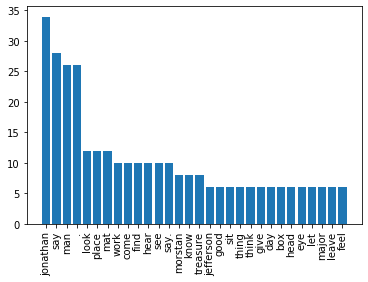

In [242]:
from groupings import *
dict = count_occurences(find_groupings(raw_text, 'hope')) #a study in scarlet
dict = count_occurences(find_groupings(raw_text, 'lupin')) #arsene lupin versus sherlock holmes
dict = count_occurences(find_groupings(raw_text, 'stapleton')) #the hound of the baskervilles
dict = count_occurences(find_groupings(raw_text, 'priest')) #mystery of cloomber
dict = count_occurences(find_groupings(raw_text, 'small')) #the sign of four

# print(dict)

graph_occurences(dict)

---
# Archive

In [ ]:
def porters_alg(text):
    # https://vijinimallawaarachchi.com/2017/05/09/porter-stemming-algorithm/#:~:text=The%20Porter%20Stemming%20algorithm%20(or,of%20Information%20Retrieval%20(IR).
    # https://tartarus.org/martin/PorterStemmer/
    m = re.match(r'(\w+?)(?=ly|es|(?<!s)s|y)', text)
    print(m.groups())
porters_alg('caresses days cates')

In [ ]:
raw_chapters[0]

In [ ]:
raw_chapters[1]

In [ ]:
list(filter(lambda c: len(c) > 50, raw_chapters))

In [ ]:
from utils.regex_utils import *

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
with open('stopwords.txt', 'w',encoding='utf-8') as f:
    for w in nlp.Defaults.stop_words:
        f.write(w + '\n')


In [ ]:
len(nlp.Defaults.stop_words)

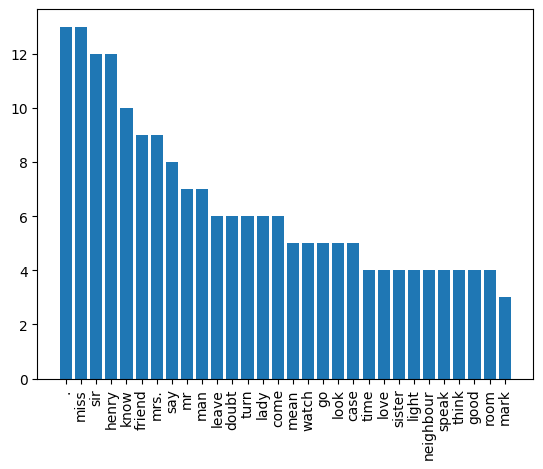